In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import newton
from scipy.optimize import minimize
import scipy.optimize as optimize
!pip install pykalman


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pykalman]


# Professional project


## Pricing functions of future


In [2]:
def futures_price_ln_risk_neutral(X0, xi0, mu, sigma, kappa, rho, lambda_X, lambda_xi, T):
    """
    Calculate the natural logarithm of the futures price using the risk-neutral model adjustments.
    
    Parameters:
    - X0 (float): Initial deviation.
    - xi0 (float): Initial Euilibrium Price level.
    - mu (float): Mean of the Euilibrium Price level.
    - sigma (float): Volatility.
    - kappa (float): Coeffiecient of mean reversion.
    - rho (float): Correlation between short-run deviations and equilibrium level its volatility.
    - lambda_X (float): Risk premium adjustment for the short run deviations.
    - lambda_xi (float): Risk premium adjustment for the equilibrium price level.
    - T (float): Time to maturity of the futures contract.
    
    Returns:
    - float: Natural logarithm of the futures price.
    """
    # Adjusted risk-neutral parameters
    mu_star = mu - lambda_X 
    xi_star = xi0  # Assuming xi0 already considers risk-neutral setup

    # e^(-kappa * T)
    exp_neg_kappa_T = np.exp(-kappa * T)
    
    # 1 - e^(-kappa * T)
    one_minus_exp_neg_kappa_T = 1 - exp_neg_kappa_T
    
    # A(T) calculation with risk-neutral adjustments
    A_T = mu_star * T - (one_minus_exp_neg_kappa_T * lambda_X / kappa) \
          + 0.5 * (((one_minus_exp_neg_kappa_T + exp(2))* sigma**2 / kappa) + sigma**2 * T) \
          + 2 * (one_minus_exp_neg_kappa_T * rho * sigma * sigma / kappa)
    
    # ln(F_T,0) calculation
    ln_F_T0 = exp_neg_kappa_T * X0 + xi_star + A_T
    
    return ln_F_T0

# Example call to the function (commented out for initial submission)
# print(futures_price_ln_risk_neutral(100, 0, 0.05, 0.2, 0.3, 0.1, 0.01, 0.01, 1))  # Replace with actual parameters to test


In [3]:
# Function to simulate the paths for short-term deviation and equilibrium level
def simulate_paths(n_simulations, n_steps, dt, xi_0, eta_0, kappa, sigma_xi, mu, sigma_eta, rho):
    # Brownian motions
    dW_xi = np.random.normal(scale=np.sqrt(dt), size=(n_simulations, n_steps))
    dW_eta = rho * dW_xi + np.sqrt(1 - rho**2) * np.random.normal(scale=np.sqrt(dt), size=(n_simulations, n_steps))

    # Initialize paths
    xi_paths = np.zeros((n_simulations, n_steps + 1))
    eta_paths = np.zeros((n_simulations, n_steps + 1))
    xi_paths[:, 0] = xi_0
    eta_paths[:, 0] = eta_0

    # Simulate the path using Euler-Maruyama method
    for t in range(1, n_steps + 1):
        xi_paths[:, t] = xi_paths[:, t - 1] - kappa * xi_paths[:, t - 1] * dt + sigma_xi * dW_xi[:, t - 1]
        eta_paths[:, t] = eta_paths[:, t - 1] + (mu - 0.5 * sigma_eta**2) * dt + sigma_eta * dW_eta[:, t - 1]

    return xi_paths, eta_paths

## Parameters

In [4]:
# Parameters for the short-term deviation and equilibrium price level
kappa = 1.49  # mean reversion rate for short-term deviation
sigma_x = 0.286  # volatility of short-term deviation
sigma_epsilon = 0.145 # volatility of the equilibrium price level
mu_epsilon = -0.0125
mu_epsilon_star = 0.0115  # drift rate for the equilibrium price level
lambda_x = 0.157
rho_epsilon_x = 0.300   # correlation between dξ and dη
r= 0.05 #risk_free_rate 

# Time parameters
dt = 1/252  # daily time step (assuming 252 trading days per year)
T = 1  # time horizon (1 year)

# Number of steps and simulations
n_steps = int(T / dt)
n_simulations = 1000

# Initial conditions
S0 = 19.61
xi_0 = 0.119  # initial short-term deviation
eta_0 = 2.857  # initial log of the equilibrium price (assuming $50 as initial price)



### A(T)

In [5]:
def calculate_A(T, kappa, sigma_x, lambda_x, mu_epsilon_star, sigma_epsilon, rho_epsilon_x):
    term1 = mu_epsilon_star * T
    term2 = (1 - np.exp(-kappa * T)) * lambda_x / kappa
    term3 = 0.5 * (1 - np.exp(-2 * kappa * T)) * sigma_x**2 / (2 * kappa)
    term4 = sigma_epsilon**2 * T
    term5 = 2 * (1 - np.exp(-kappa * T)) * rho_epsilon_x * sigma_x * sigma_epsilon / kappa
    return term1 - term2 + term3 + term4 + term5


# Calculate forward price using the exact formula
A_T = calculate_A(T, kappa, sigma_x, lambda_x, mu_epsilon_star, sigma_epsilon, rho_epsilon_x)
X0 = np.log(S0)  # 初始对数价格
delta_0 = 0.119 


### Monte Carlo Simulation

In [6]:

# Monte Carlo simulation of forward prices
def calculate_future_price(S0, X0, delta_0, kappa, T, A_T):
    ln_F_T0 = np.exp(-kappa * T) * X0 + np.exp(-kappa * T) * delta_0 + A_T
    return np.exp(ln_F_T0)

future_prices = np.zeros(n_simulations)
for i in range(n_simulations):
    future_prices[i] = calculate_future_price(S0, X0, delta_0, kappa, T, A_T)


price_paths = np.zeros((n_simulations, n_steps))
price_paths[:, 0] = S0

for i in range(1, n_steps):
    dW = np.random.normal(scale=np.sqrt(dt), size=n_simulations)
    price_paths[:, i] = price_paths[:, i-1] * np.exp((mu_epsilon_star - 0.5 * sigma_epsilon**2) * dt + sigma_epsilon * dW)

### option

Average Calculated Futures Price:  1.962861434348778
Average Call Option Price:  1.3945987770137385


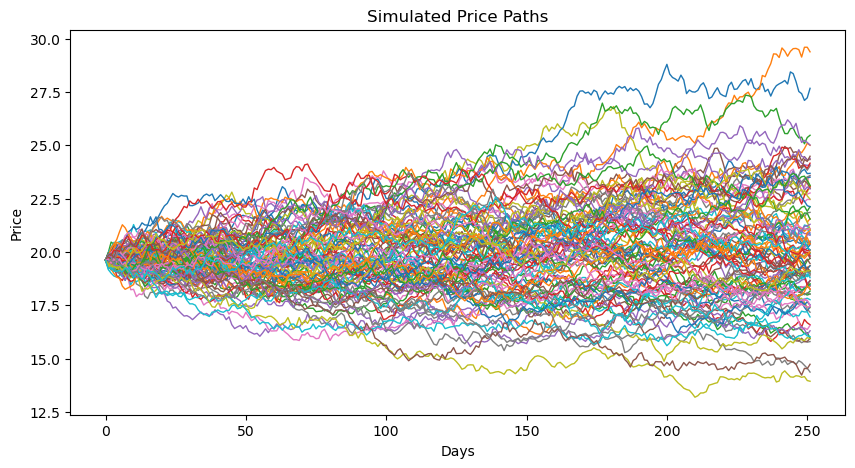

In [7]:
# Function to calculate European option prices on futures
strike_price = 20
call_prices = np.zeros(n_simulations)

for i in range(n_simulations):
    ST = price_paths[i, -1]
    d1 = (np.log(ST / strike_price) + (r + 0.5 * sigma_epsilon**2) * T) / (sigma_epsilon * np.sqrt(T))
    d2 = d1 - sigma_epsilon * np.sqrt(T)
    call_price = np.exp(-r * T) * (ST * norm.cdf(d1) - strike_price * norm.cdf(d2))
    call_prices[i] = call_price

# Output the average forward price and average option price

average_future_price = np.mean(future_prices)
print("Average Calculated Futures Price: ", average_future_price)
print("Average Call Option Price: ", np.mean(call_prices))

# Plot paths
plt.figure(figsize=(10, 5))
for i in range(min(100, n_simulations)):  # Plot multiple paths, but do not exceed the total number of simulations
    plt.plot(price_paths[i], lw=1)
plt.title('Simulated Price Paths')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


### Characteristic equation

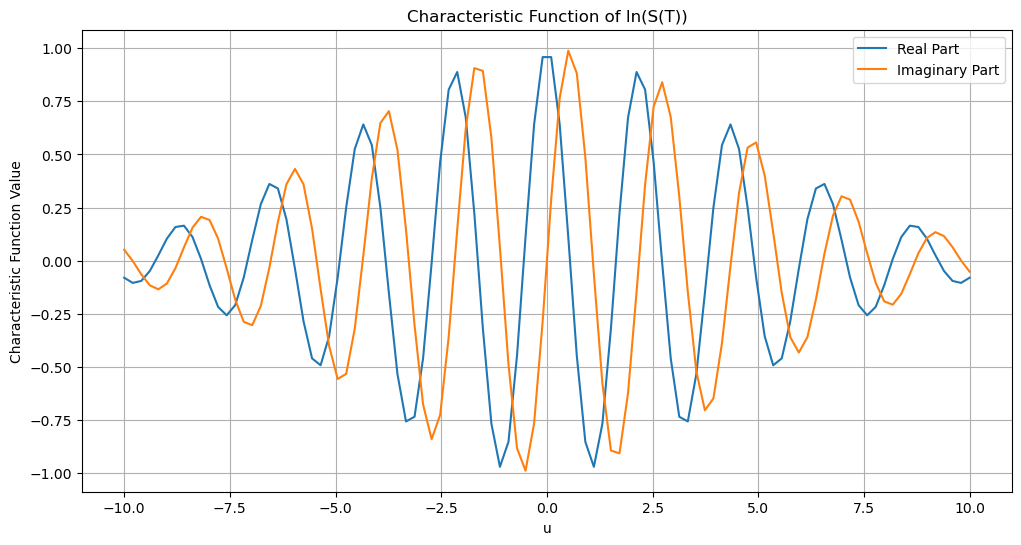

In [13]:
# Calculate means and variances at time T
mean_xi_T = xi_0 * np.exp(-kappa * T)
var_xi_T = sigma_x**2 * (1 - np.exp(-2 * kappa * T)) / (2 * kappa)

mean_eta_T = eta_0 + (mu_epsilon_star - 0.5 * sigma_epsilon**2) * T
var_eta_T = sigma_epsilon**2 * T

# Total mean and variance of ln(S(T)) = eta_T + xi_T
mean_ln_ST = mean_eta_T + mean_xi_T
var_ln_ST = var_eta_T + var_xi_T

# Define the characteristic function for ln(S(T))
def characteristic_function_ln_ST(u):
    return np.exp(1j * u * mean_ln_ST - 0.5 * u**2 * var_ln_ST)

# Evaluate the characteristic function at various points
u_values = np.linspace(-10, 10, 100)
char_func_values = np.array([characteristic_function_ln_ST(u) for u in u_values])

# Plot the real and imaginary parts of the characteristic function
plt.figure(figsize=(12, 6))
plt.plot(u_values, char_func_values.real, label='Real Part')
plt.plot(u_values, char_func_values.imag, label='Imaginary Part')
plt.title('Characteristic Function of ln(S(T))')
plt.xlabel('u')
plt.ylabel('Characteristic Function Value')
plt.legend()
plt.grid(True)
plt.show()


## Kalman Filter

Optimized Transition Matrices for 1 month: [[0.88323262 0.        ]
 [0.         1.        ]]
Optimized Observation Covariance for 1 month: [[0.00143114]]


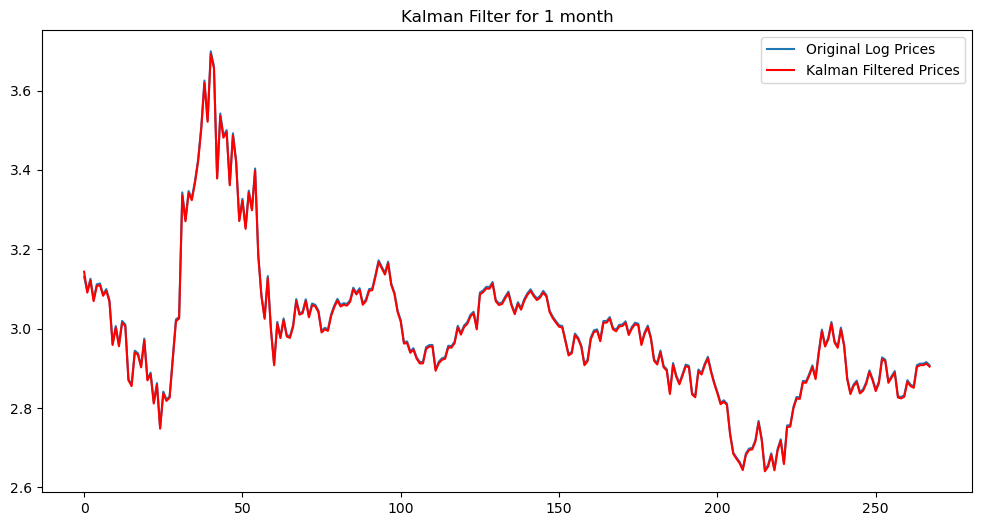

Optimized Transition Matrices for 5 months: [[0.88323262 0.        ]
 [0.         1.        ]]
Optimized Observation Covariance for 5 months: [[0.00136466]]


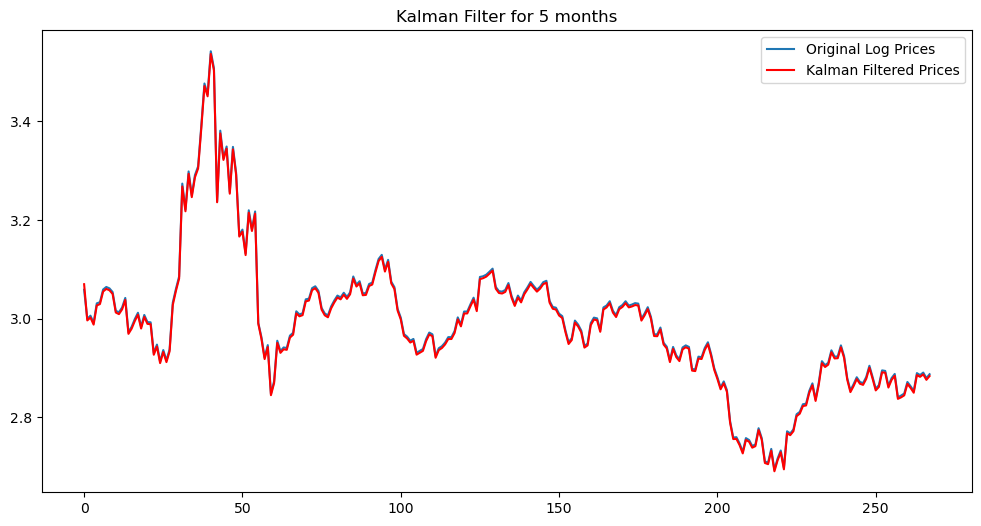

Optimized Transition Matrices for 9 months: [[0.88323262 0.        ]
 [0.         1.        ]]
Optimized Observation Covariance for 9 months: [[0.00134239]]


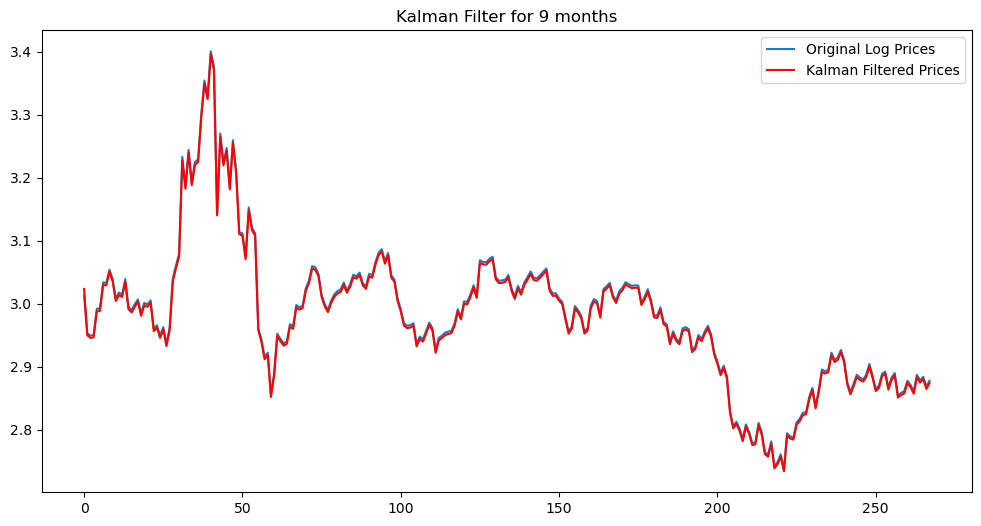

Optimized Transition Matrices for 13 months: [[0.88323262 0.        ]
 [0.         1.        ]]
Optimized Observation Covariance for 13 months: [[0.0013319]]


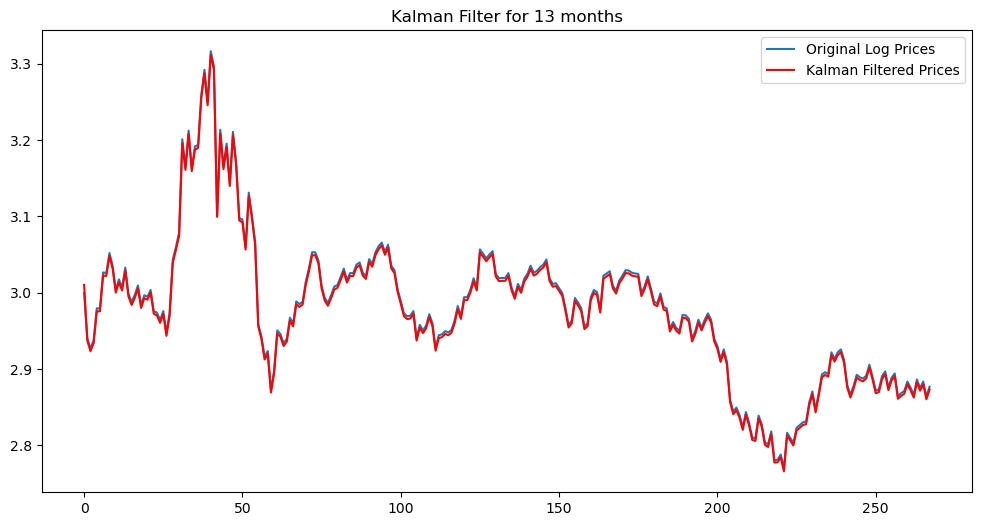

Optimized Transition Matrices for 17 months: [[0.88323262 0.        ]
 [0.         1.        ]]
Optimized Observation Covariance for 17 months: [[0.00132741]]


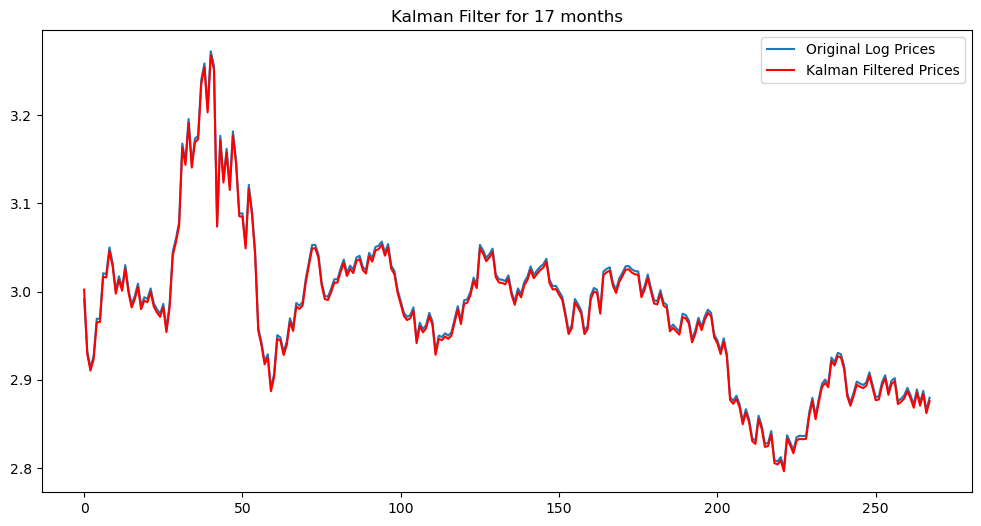

In [19]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

# load data
data = pd.read_excel("../data/Prices.xlsx")

# initialize
kappa = 1.49
sigma_x = 28.6 / 100
sigma_epsilon = 14.5 / 100
delta_t = 1/12  # Assume each time step represents one month


for column in data.columns:
    prices = np.log(data[column].dropna())  # Convert prices to log and drop NaN values

    # initialize karlmanfilter parameter
    initial_state_mean = [prices.iloc[0], 0]  # Starting state
    initial_state_covariance = np.eye(2) * 0.1  # Small initial state covariance
    transition_matrices = np.array([[np.exp(-kappa * delta_t), 0], [0, 1]])
    observation_matrices = np.array([[1, 0]])  # Single observation dimension
    transition_covariance = np.array([[sigma_x**2, 0], [0, sigma_epsilon**2]]) * delta_t
    observation_covariance = np.array([[0.042**2]])  # Match the observation error variance

    # emprical
    kf = KalmanFilter(
        transition_matrices=transition_matrices,
        observation_matrices=observation_matrices,
        transition_covariance=transition_covariance,
        observation_covariance=observation_covariance,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance
    )

    # EM 
    kf = kf.em(prices.values[:, None], n_iter=5)  # Use EM to estimate parameters

    # KalmanFilter
    state_estimates, _ = kf.filter(prices.values[:, None])

    # outcome optimize parameter
    print(f"Optimized Transition Matrices for {column}:", kf.transition_matrices)
    print(f"Optimized Observation Covariance for {column}:", kf.observation_covariance)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(prices.index, prices, label='Original Log Prices')
    plt.plot(prices.index, state_estimates[:, 0], label='Kalman Filtered Prices', color='red')
    plt.title(f'Kalman Filter for {column}')
    plt.legend()
    plt.show()